In [7]:
from dyadic_fem import *
%matplotlib inline
# Remember: if we want interactive 3D plots use %matplotlib notebook

## First we check our FEM solution against a known analytic solution
Here we solve the problem $$-\nabla \cdot (a(x) \nabla u(x)) = f(x)$$ using FEM, where $a(x)=1$ is constant, with  homogeneous Dirichlet bdry conditions and $f(x) = 1$. This is the Poisson equation and has a known analytic solution, which we check our solution against. 

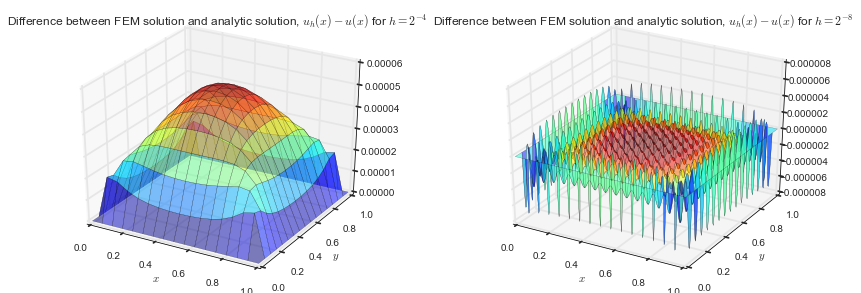

In [3]:
constant_field = ConstantField(c=1.0)

fem_coarse = DyadicFEMSolver(div=4, rand_field=constant_field, f=1.0)
fem_fine = DyadicFEMSolver(div=8, rand_field=constant_field, f=1.0)

# We make the appropriate grid for both the fine and the coarse FEM solution
x = np.linspace(0.0, 1.0, fem_coarse.n_side + 2, endpoint = True) 
xs_coarse, ys_coarse = np.meshgrid(x, x)
x = np.linspace(0.0, 1.0, fem_fine.n_side + 2, endpoint = True) 
xs_fine, ys_fine = np.meshgrid(x, x)

def analytic_soln(x,y,N=16,M=16):
    # This is the standard series solution for the Poisson problem on the unit square 
    # with homogeneous dirichelet boundaries and uniform force f=1
    soln = np.zeros(x.shape)
    for i in range(N):
        for j in range(M):
            n = 2*i+1
            m = 2*j+1
            soln = soln + (4.0 / (math.pi*math.pi*math.pi*math.pi)) * (1.0/(n*m*(n*n + m*m))) * \
                    np.sin(n*math.pi*x) * np.sin(m*math.pi*y)   
    return soln

# Solve both the FEM problems
fem_coarse.solve()
fem_fine.solve()

analytic_coarse = DyadicPWLinear(analytic_soln(xs_coarse, ys_coarse), 4)
analytic_fine = DyadicPWLinear(analytic_soln(xs_fine, ys_fine), 8)

# Now just plot the difference between the analytic solution and the FEM solution
fig = plt.figure(figsize=(14, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
(analytic_coarse - fem_coarse.u).plot(ax, title='Difference between FEM solution and analytic solution, $u_h(x) - u(x)$ for $h=2^{-4}$')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
(analytic_fine - fem_fine.u).plot(ax2, title='Difference between FEM solution and analytic solution, $u_h(x) - u(x)$ for $h=2^{-8}$')

plt.show()

We see that the FEM solution on the $2^8$ subdivided square (RHS above) has converged closer to the analytic solution than the $2^4$ subdivided square (LHS above).

# We trust our FEM solution is correct, now we try arbitrary dyadic fields

Here we solve the problem $$-\nabla \cdot (a(x) \nabla u(x)) = f(x)$$ using FEM,where $a(x)$ is a randomly generated piecewise constant function on the dyadic subdivision of the unit square. The field is given by 
$$ a(x) = \bar{a} + c \sum_i y_i \mathbb{1}_{s_i}(x) $$
where $\bar{a}$ and $c$ are constants (given below), $y_i$ is a uniform RV from $[-1,1]$, and $\mathbb{1}_{s_i}$ is the indicator function on the $i$-th dyadic square $s_i$.

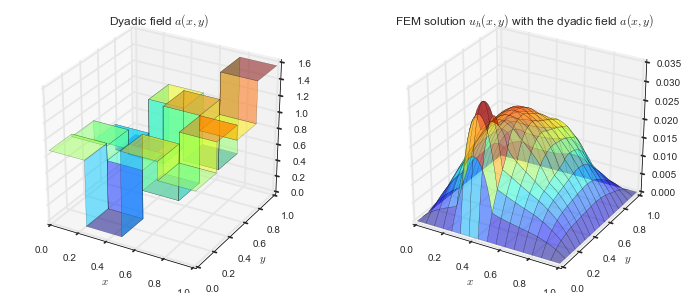

In [11]:
a = DyadicRandomField(div=2, a_bar=1.0, c=0.99, seed=2)
fem = DyadicFEMSolver(div=6, rand_field=a, f=1.0)

fem.solve()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.field.plot(ax, title='Dyadic field $a(x,y)$')
ax = fig.add_subplot(1, 2, 2, projection='3d')
fem.u.plot(ax, title='FEM solution $u_h(x,y)$ with the dyadic field $a(x,y)$')
plt.show()

## Test L2 and H1 inner product routines in DyadicPWLinear
We test the $L^2$ and $H^1_0$ norms for functions in $U_h$ (our dyadic triangulation subspace), for a test function $u(x,y) = \sin(\pi x) \sin(\pi y)$, that has known analytic values of $\| u \|_{L^2} = 1/4$ and $\| u \|_{H^1_0} = \pi^2 / 2 + 1/4$

In [2]:
print('Testing convergence of L2 norm to analytic soln of 0.25 \n \
and H1 norm to pi^2 / 2, for increasing dyadic subdiv')
for div in range(2,12,2):
    
    xs = np.linspace(0.0, 1.0, 2**div+1, endpoint=True)
    x,y = np.meshgrid(xs, xs)
    
    u = DyadicPWLinear(np.sin(math.pi*x)*np.sin(math.pi*y), div)
    
    print('Dyadic lev.', div, '\tL2:', u.L2_dot(u), '\tH1_0:', u.H1_dot(u))
    # NB the L2 norm should be close to (u.values * u.values).sum() / ((2**div+1) * (2**div+1)),

print('Analytic \tL2:', 0.25, '\t\tH1_0:', math.pi * math.pi / 2.0 + 0.25)

Testing convergence of L2 norm to analytic soln of 0.25 
 and H1 norm to pi^2 / 2, for increasing dyadic subdiv
Dyadic lev. 2 	L2: 0.204758898432 	H1_0: 4.89105039945
Dyadic lev. 4 	L2: 0.246812930294 	H1_0: 5.16578114707
Dyadic lev. 6 	L2: 0.249799303156 	H1_0: 5.18361068677
Dyadic lev. 8 	L2: 0.249987450543 	H1_0: 5.18472772037
Dyadic lev. 10 	L2: 0.249999215636 	H1_0: 5.18479754549
Analytic 	L2: 0.25 		H1_0: 5.184802200544679


## Now we look at coarse grid approximations, where $V_n$ is the space of $n$ coarse grid hat functions
This code computes an FEM solution $u_h$ from $a$. We have a full set of coarse grid hat functions $V_n = \{ v_1, v_2, \ldots, v_n\}$, i.e. $n = (2^d-1) \times (2^d - 1)$ where $d = \mathtt{coarse\_div}$, the dyadic level of the coarse grid, that is we have a hat function for every possible point in the grid that is not on the boundary. We compute the set of inner products $$w_i = \langle v_i, u_h \rangle$$ 
where the inner product is both the $L^2$ and $H^1_0$ inner product. $V_n$ is not orthonormal, so we must do some linear algebra...

We reconstruct the function by computing the matrix $\mathbf{\Phi}$, where $$\Phi_{i,j} = \langle v_i, v_j \rangle$$ and we then solve the system $$\mathbf{\Phi} \mathbf{y} = \mathbf{w}$$ where $\mathbf{w}$ is the vector with values $w_i$. We solve for $\mathbf{y}$, and our reconstruction is then $$\hat{u}_h(x) = \sum_{i=1}^n y_i v_i(x)$$ which we plot and look at the differences.

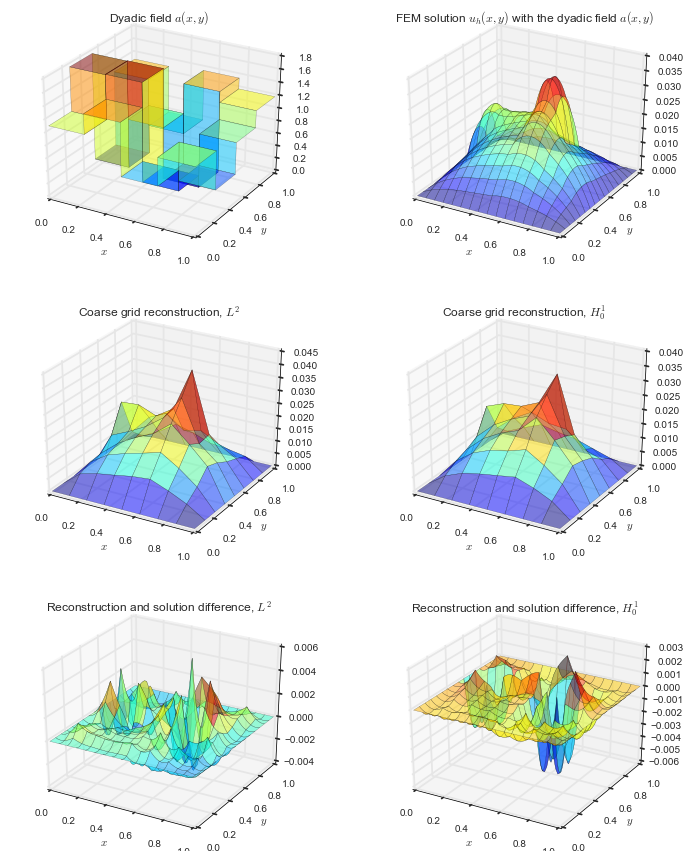

In [12]:
from dyadic_fem import *

# The dyadic divisino levels for the random field, the FEM solution, and the
# approximate solution space v_n
field_div = 2
fem_div = 6
coarse_div = 3

a = DyadicRandomField(div=field_div, a_bar=1.0, c=0.99, seed=3)
fem = DyadicFEMSolver(div=fem_div, rand_field=a, f=1.0)

fem.solve()
V_n = []

Phi_L2 = np.zeros([(2**coarse_div-1) * (2**coarse_div-1), (2**coarse_div-1) * (2**coarse_div-1)])
Phi_H1 = np.zeros([(2**coarse_div-1) * (2**coarse_div-1), (2**coarse_div-1) * (2**coarse_div-1)])
w_L2 = np.zeros((2**coarse_div-1) * (2**coarse_div-1))
w_H1 = np.zeros((2**coarse_div-1) * (2**coarse_div-1))
for i in range(2**coarse_div-1):
    for j in range(2**coarse_div-1):
        v_n = DyadicPWLinear(div = coarse_div)
        v_n.values[i+1, j+1] = 1.0
        V_n.append(v_n)
        
        # Now we take the L2 / H1_0 dot product between this and the FEM soln
        w_H1[(2**coarse_div-1) * i + j] = fem.u.H1_dot(v_n)
        w_L2[(2**coarse_div-1) * i + j] = fem.u.L2_dot(v_n)
        
        # And build the co-dependence matrix at the same time...
        for i2 in range(2**coarse_div-1):
            for j2 in range(2**coarse_div-1):
                v_n2 = DyadicPWLinear(div = coarse_div)
                v_n2.values[i2+1,j2+1] = 1.0
                
                Phi_L2[i * (2**coarse_div-1) + j, i2 * (2**coarse_div-1) + j2] = v_n.L2_dot(v_n2)
                Phi_H1[i * (2**coarse_div-1) + j, i2 * (2**coarse_div-1) + j2] = v_n.H1_dot(v_n2)

# Now we get the coefficients by solving the linear system (BTW We'll do this in the next section with Gram-Schmidt/
# QR factorisation... much easier and quicker...)
y_L2 = np.linalg.solve(Phi_L2, w_L2)
y_H1 = np.linalg.solve(Phi_H1, w_H1)
                
u_hat_L2 = DyadicPWLinear(div = coarse_div)
u_hat_H1 = DyadicPWLinear(div = coarse_div)

u_hat_L2.values[1:-1,1:-1] = y_L2.reshape([2**coarse_div-1, 2**coarse_div-1])
u_hat_H1.values[1:-1,1:-1] = y_H1.reshape([2**coarse_div-1, 2**coarse_div-1])

fig = plt.figure(figsize=(12, 15))

ax = fig.add_subplot(3, 2, 1, projection='3d')
a.field.plot(ax, title='Dyadic field $a(x,y)$')

ax = fig.add_subplot(3, 2, 2, projection='3d')
fem.u.plot(ax, title='FEM solution $u_h(x,y)$ with the dyadic field $a(x,y)$')

ax = fig.add_subplot(3, 2, 3, projection='3d')
u_hat_L2.plot(ax, title='Coarse grid reconstruction, $L^2$')

ax = fig.add_subplot(3, 2, 4, projection='3d')
u_hat_H1.plot(ax, title='Coarse grid reconstruction, $H^1_0$')

ax = fig.add_subplot(3, 2, 5, projection='3d')
(u_hat_L2 - fem.u).plot(ax, title='Reconstruction and solution difference, $L^2$')

ax = fig.add_subplot(3, 2, 6, projection='3d')
(u_hat_H1 - fem.u).plot(ax, title='Reconstruction and solution difference, $H^1_0$')

plt.show()

## Now we do the same but by first constructing an orthonormal basis from our set $V_n$

In [ ]:
from dyadic_fem import *

# We use the same parameters and Phi as in the last section.

q_L2, r_L2 = np.linalg.qr(Phi_L2)
q_H2, r_H2 = np.linalg.qr(Phi_L2)

n = (2**coarse_div-1) * (2**coarse_div-1)

Vstar_n

# Now construct our orthonormal basis functions
for i in range(n):
    vstar_n = 
    for j in range(n)
        
